# Project 1: South African Heart Disease

Group 22


In [1]:
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, show, clim, semilogx, loglog, title, subplot, grid
from scipy.io import loadmat

import sklearn.linear_model as lm
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from sklearn import model_selection, tree
from scipy import stats
import torch
import seaborn as sns

from toolbox_02450 import feature_selector_lr, bmplot, rlr_validate, train_neural_net

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Load data from csv and store it in dataframe'
df = pd.read_csv('SAheart.data.txt')

## Data visualization

In [3]:
# Change variables to integers: Replace absent and present by 0 and 1
df = df.replace('Absent',0)
df = df.replace('Present',1)
df

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...,...
457,459,214,0.40,5.98,31.72,0,64,28.45,0.00,58,0
458,460,182,4.20,4.41,32.10,0,52,28.61,18.72,52,1
459,461,108,3.00,1.59,15.23,0,40,20.09,26.64,55,0
460,462,118,5.40,11.61,30.79,0,64,27.35,23.97,40,0


In [4]:
# Drop row column
df.drop(['row.names'], axis = 'columns', inplace=True) 

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
sbp,1.000000,0.212247,0.158296,0.356500,0.085645,-0.057454,0.238067,0.140096,0.388771,0.192354
tobacco,0.212247,1.000000,0.158905,0.286640,0.088601,-0.014608,0.124529,0.200813,0.450330,0.299718
ldl,0.158296,0.158905,1.000000,0.440432,0.161353,0.044048,0.330506,-0.033403,0.311799,0.263053
adiposity,0.356500,0.286640,0.440432,1.000000,0.181721,-0.043144,0.716556,0.100330,0.625954,0.254121
famhist,0.085645,0.088601,0.161353,0.181721,1.000000,0.044809,0.115595,0.080520,0.239667,0.272373
typea,-0.057454,-0.014608,0.044048,-0.043144,0.044809,1.000000,0.074006,0.039498,-0.102606,0.103156
obesity,0.238067,0.124529,0.330506,0.716556,0.115595,0.074006,1.000000,0.051620,0.291777,0.100095
alcohol,0.140096,0.200813,-0.033403,0.100330,0.080520,0.039498,0.051620,1.000000,0.101125,0.062531
age,0.388771,0.450330,0.311799,0.625954,0.239667,-0.102606,0.291777,0.101125,1.000000,0.372973
chd,0.192354,0.299718,0.263053,0.254121,0.272373,0.103156,0.100095,0.062531,0.372973,1.000000


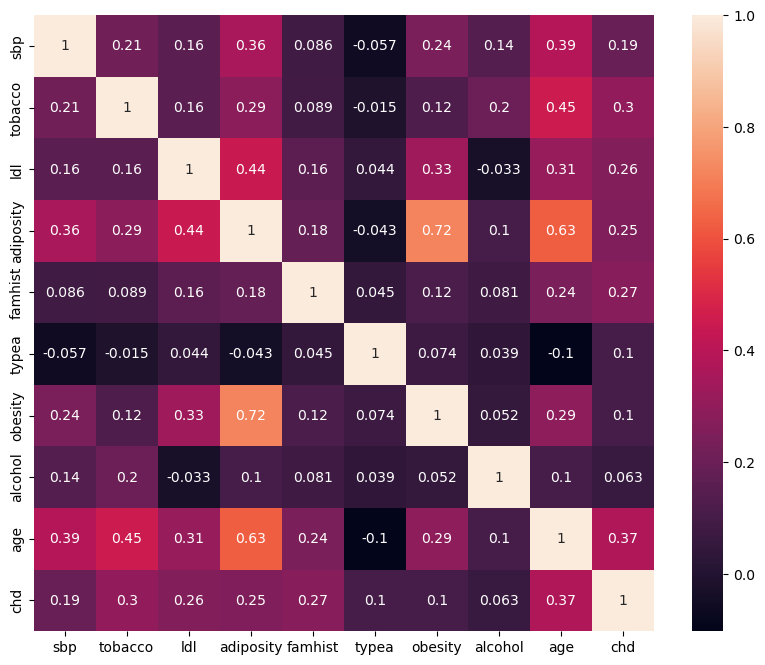

In [5]:
# Plot disperssion matrix to see correlation
f, ax = plt.subplots(figsize = (10, 8))
corr = df.corr()
sns.heatmap(corr,annot = True,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values)

df.corr()

In [6]:
# Create matrix with values
raw_data = df.values  
cols = range(0, 9) 
X = raw_data[:, cols]
X = np.asarray(X, dtype = np.intc)
attributeNames = np.asarray(df.columns[cols])
classLabels = raw_data[:,-1]
classNames = sorted(set(classLabels))
classDict = dict(zip(classNames,range(len(classNames))))
y = np.array([classDict[cl] for cl in classLabels])
N, M = X.shape
C = len(classNames)

We want to quantifiably analyze and select one between the attributes which is best suitable for regression analysis. 

For this, OLS linear regression model will be used as testing methodology, where we select one variable to be predicted according to all our other variables in the dataset, and measuring the values of the MSE residuals when plotting the estimated data points against the true line of fitting.

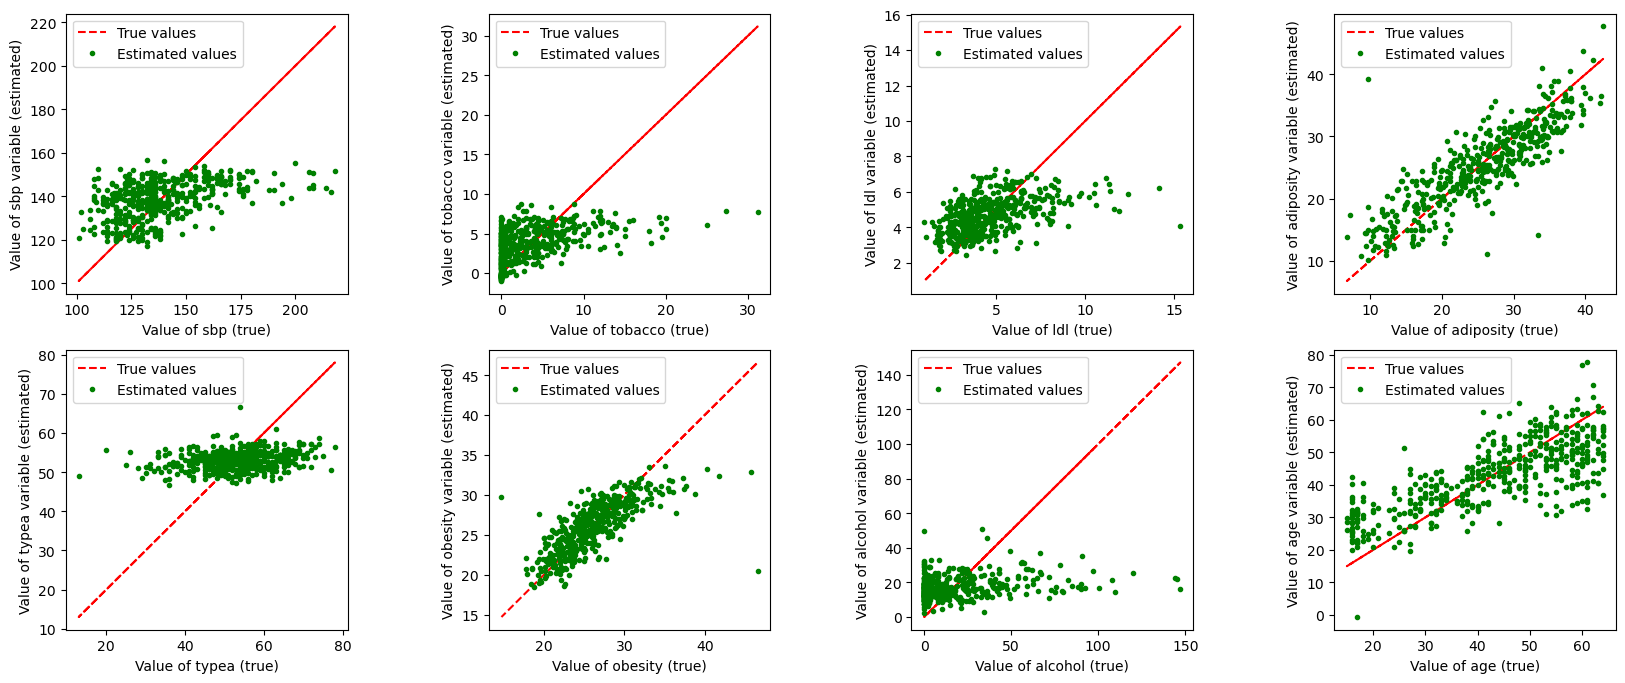

In [7]:
criterion_variables = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']

# Display plot
plt.figure(figsize=(20,8))
plt.subplots_adjust(wspace = 0.5)

for i in range(8):
    attr_col = list(df.columns).index(criterion_variables[i])
    cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

    X = raw_data[:, cols]
    y = raw_data[:, attr_col] # the 'oldpeak' column
    attributeNames = list(df.columns[cols])

    N, M = X.shape
    
    X = stats.zscore(X);

    # Fit ordinary least squares regression model    
    model = lm.LinearRegression()
    model.fit(X,y)

    # Predict thalach
    y_est = model.predict(X)
    residual = y_est-y
    
    plt.subplot(2, 4, i+1)
    plt.plot(y, y, '--r')
    plt.plot(y, y_est, '.g')
    plt.xlabel('Value of {0} (true)'.format(criterion_variables[i])); ylabel('Value of {0} variable (estimated)'.format(criterion_variables[i]))
    plt.legend(['True values', 'Estimated values'], loc = 2);


Estimation values of ‘adiposity’, ‘obesity’, and 'age' seem to align well with the line of true fit. However ‘adiposity’ has lower average MSE residuals overall, so we will choose it as our dependent variable to be estimated using all other dataset attributes.

###  Variable selection in linear regression

In a linear regression problem, we are predicting our dependent variable through a linear combination of a coupling between the values of the independent variables with some set of weights representing the magnitude and direction of influence upon the variable to be predicted. The linear model is trained/fitted to a set of pre-defined input data (i.e. training data), from which the linear regression model estimated the values of its weights for each independent variable, so as to minimize the mean residual square error. When we try to estimate the criterion variable based on new data, the linear model will use its learned weight parameters for each individual predictor variable and will output an estimate of the predictor.

We are interested in discovering whether we can improve this model by reaching the same prediction power using fewer attributes. For this purpose, we perform a forward selection test with cross-validation across 5 outer folds and 10 inner folds, where we train a model starting with no features and gradually select and add, one-by-one, the features which minimize the squared error in the inner cross-validation loop, until the error cannot be minimized by adding any further predictors. Finally, we compute the R2 value of both the full model without feature selection and the newly-fitted feature-selecting model upon a test set, in order to see what percentage of the variance within the dataset is explained by each model.

Linear regression without feature selection:
- Training error: 7.676061889686345
- Test error:     8.101872462905868
- R^2 train:     0.5667011127187076
- R^2 test:     0.5400014349627128


Linear regression with feature selection:
- Training error: 7.75700744732674
- Test error:     7.971675412999581
- R^2 train:     0.5621318921261702
- R^2 test:     0.5473936095992782


Text(0, 0.5, 'Attribute')

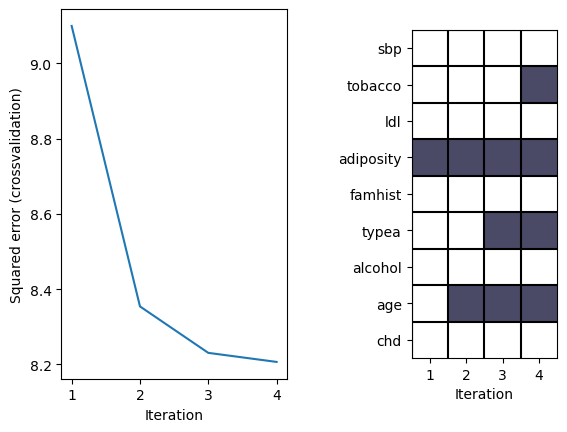

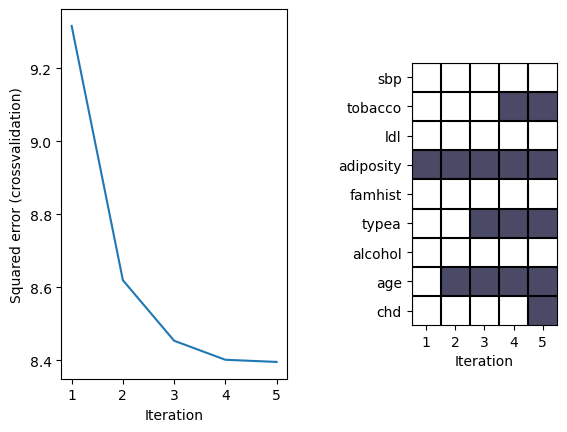

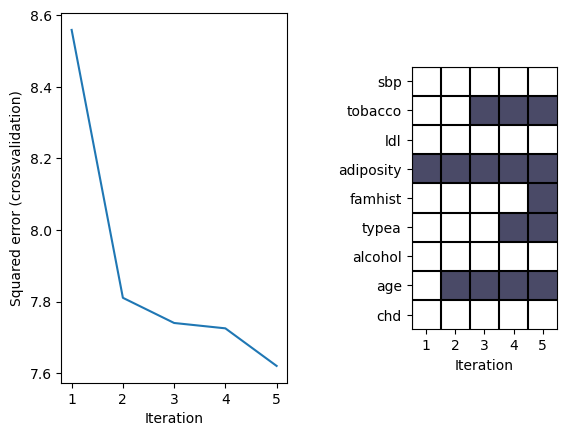

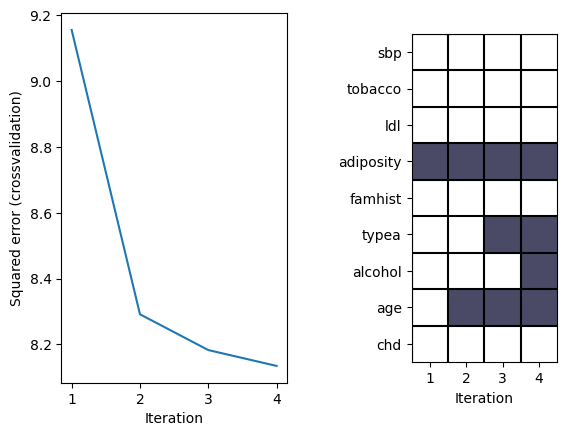

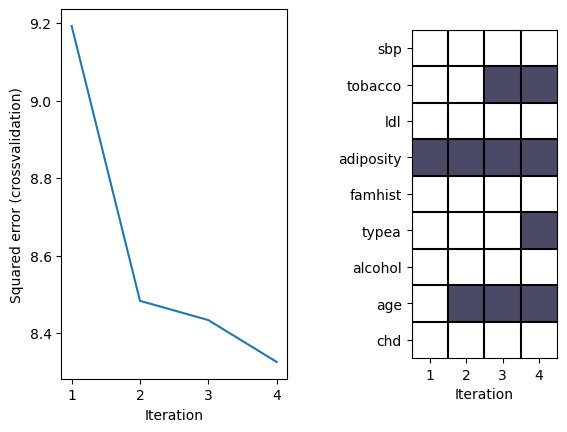

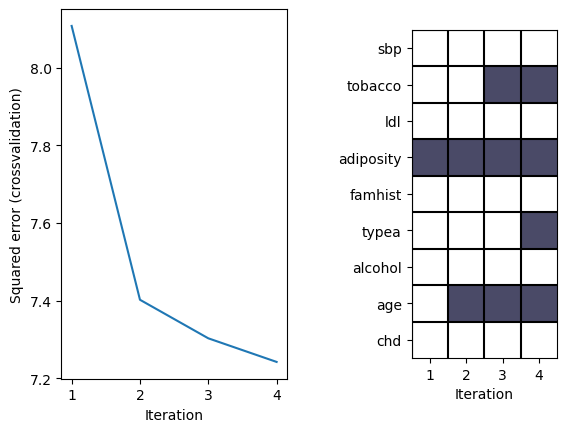

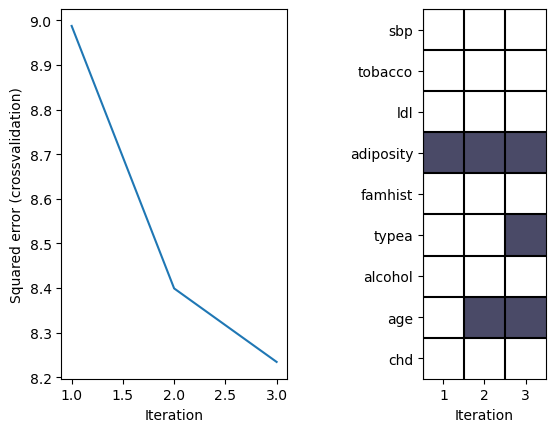

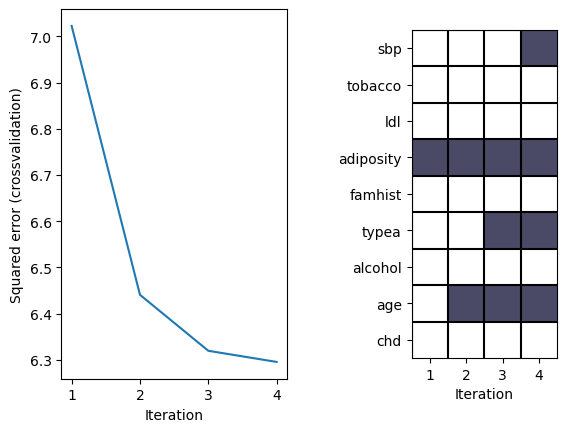

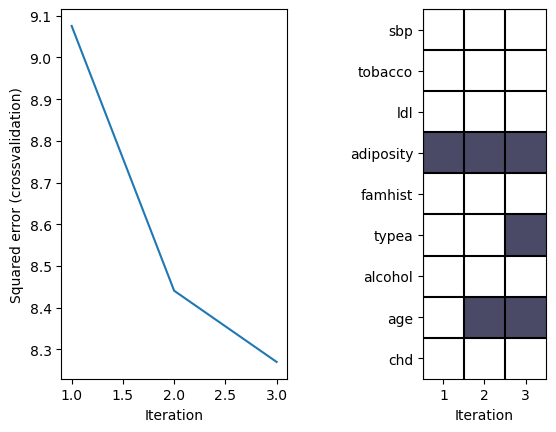

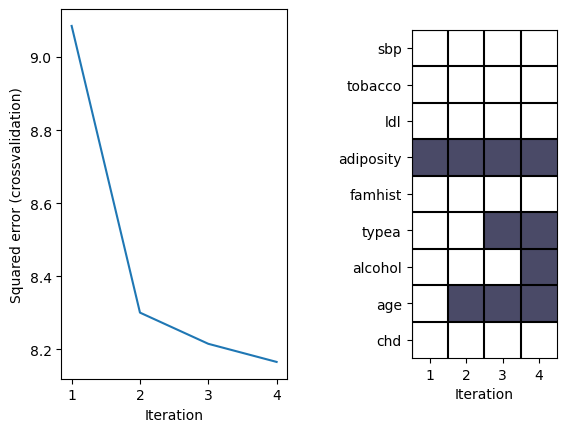

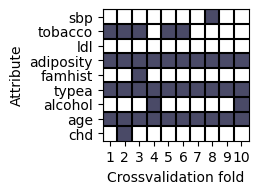

In [8]:
raw_data = df.to_numpy()
attr_col = list(df.columns).index('obesity')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col] # the 'adiposity' column
attributeNames = list(df.columns[cols])
N, M = X.shape

X = stats.zscore(X)

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV.split(X):
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    textout = ''
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k] = 1
    # .. alternatively you could use module sklearn.feature_selection
    
    if len(selected_features) == 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')

    #print('Cross validation fold {0}/{1}'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}'.format(test_index))
    #print('Features no: {0}\n'.format(selected_features.size))

    k+=1
    
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('\n')
print('Linear regression with feature selection:')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))

figure(k)
subplot(1,3,2)
bmplot(attributeNames, range(1,Features.shape[1]+1), -Features)
clim(-1.5,0)
xlabel('Crossvalidation fold')
ylabel('Attribute')

From the forward selection algorithm, we can see that our dependent variable ‘adiposity’ is best described using the features: ‘ldl’, ‘obesity’ and ‘age’, while many other variables have been left out completely from our model, due to the low assistance in further reducing the MSE of the estimates. 

However, the error results show that, there is not any improvement when using feature selection compared to using all the features. ¿?

**for predictions on a test set using the full model, ~34% of the variance is explained by the predictors (rather low for performing reliable regression), however when using the feature selected model, ~33% to ~35% of the variance is explained (depending on the extracted features). This suggests that feature selection has no optimization impact upon our regression models, and it may even increase the MSE error in some situations. This means that, even though the criterion is predicted, to a large extent by only a few numbers of attributes, the full model is definitely not overfitting on the data and even the terms having very low correlation will help slightly reduce the MSE. Re-running the test more times yielded similar results, therefore the full model will be used from further on.**

[1 3 5 7 8]


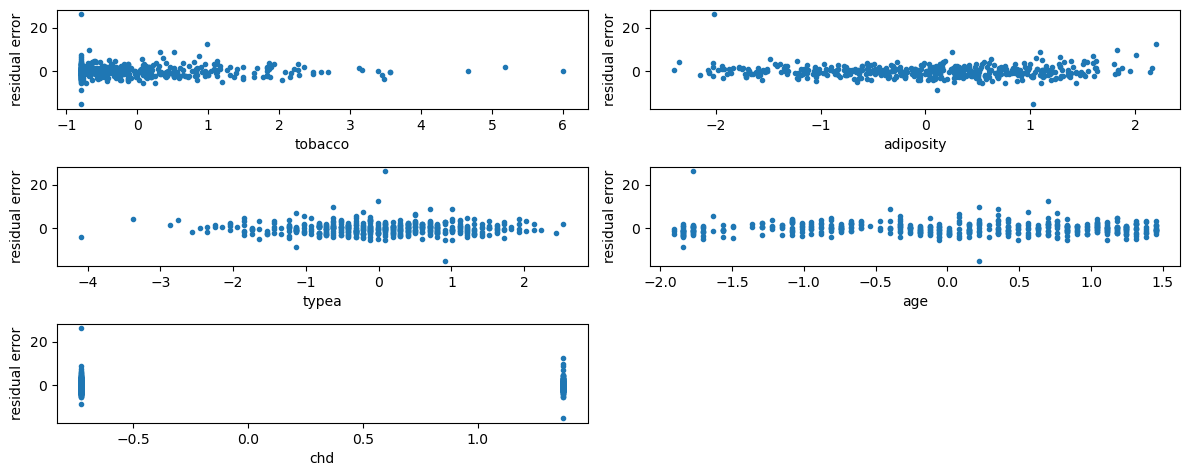

In [9]:
# Inspect selected feature coefficients effect on the entire dataset 
# and plot the fitted model residual error as function of each attribute
# to inspect for systematic structure in the residual

f=2 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
print(ff)
if len(ff) == 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X[:,ff], y)
    
    y_est= m.predict(X[:,ff])
    residual=y-y_est
    
    figure(k+1, figsize=(12,6))
    title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
    for i in range(0,len(ff)):
       subplot(4, int( np.ceil(len(ff) // 2)),i+1)
       plot(X[:,ff[i]],residual,'.')
       xlabel(attributeNames[ff[i]])
       ylabel('residual error')
    plt.tight_layout()
    
show()

### Regularization

Here we introduce a regularization parameter λ into the linear regression, which will take values between 10^-5 and 10^9because we want to obtain the lowest possible generalization error when using our linear regression model.

The role of λ, known as regularization strength, is to minimize the overall sum-of-squares error term and reduce the variance in the dataset by introducing a small amount of bias (meaning that training error will slightly increase, however, generally, generalization error will decrease).

In order to reliably estimate the generalization error for different values of λ, we have performed two-level cross-validation testing, with the outer layer having K1 = 10 folds and the inner fold being selected to K2 = 10 folds.

In [10]:
# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames= [u'Offset']+attributeNames
M = M+1
attributeNames

['Offset',
 'sbp',
 'tobacco',
 'ldl',
 'adiposity',
 'famhist',
 'typea',
 'alcohol',
 'age',
 'chd']

<Figure size 640x480 with 0 Axes>

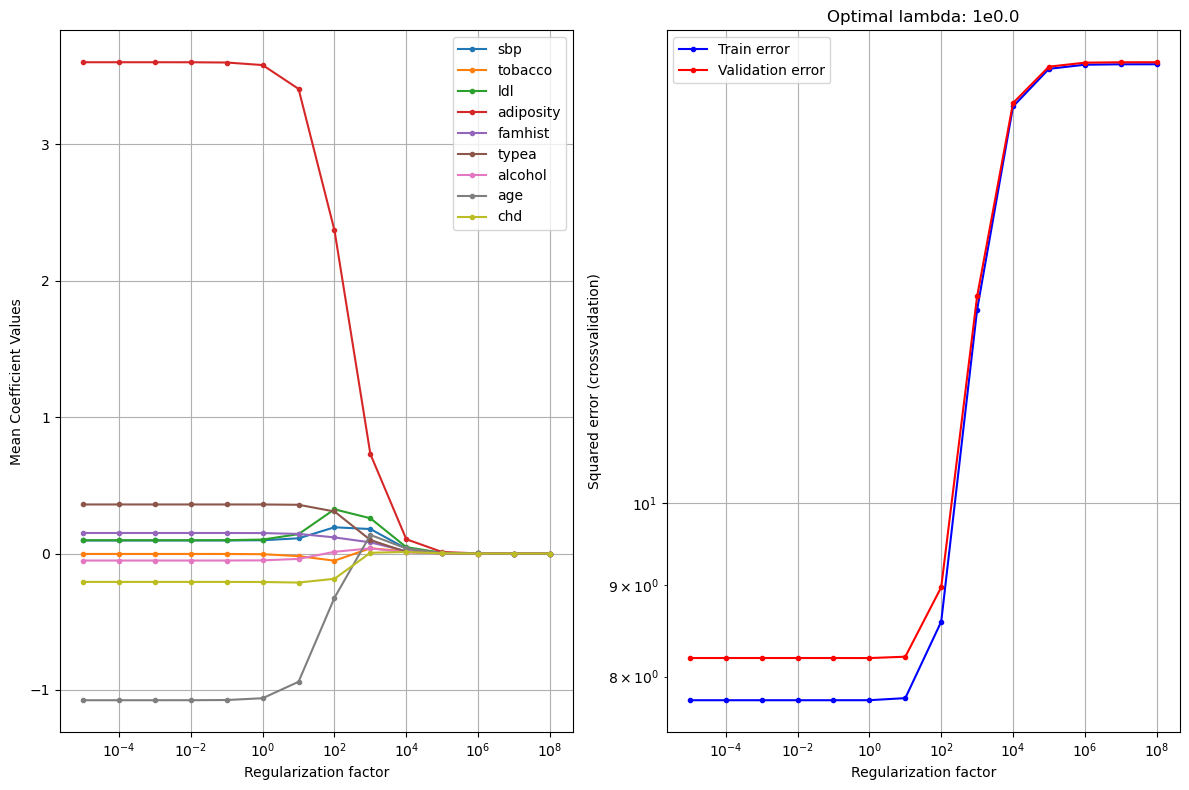

Linear regression without feature selection:
- Training error: 7.682403058804534
- Test error:     7.97181655962369
- R^2 train:     0.5663125671627366
- R^2 test:     0.5447897394809939

Regularized linear regression:
- Training error: 7.6842363486761895
- Test error:     7.9829435007815945
- R^2 train:     0.5662090741837821
- R^2 test:     0.5441543638742691

Weights in last fold:
         Offset           26.11
            sbp             0.1
        tobacco           -0.01
            ldl             0.1
      adiposity            3.58
        famhist            0.15
          typea            0.36
        alcohol           -0.05
            age           -1.06
            chd           -0.21
Generalization error for different values of lambda:
               1e-05                 8.03
              0.0001                 8.03
               0.001                 8.03
                0.01                 8.03
                 0.1                 8.03
                 1.0          

In [11]:
## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)
#CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.,range(-5,9))

# Initialize variables
#T = len(lambdas)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
val_error_lambdas = np.empty((K,len(lambdas)))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)
    val_error_lambdas[k] = test_err_vs_lambda
    
    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    #m = lm.LinearRegression().fit(X_train, y_train)
    #Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    #Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(12,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1
    plt.tight_layout()
    
show()

# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))

print('Generalization error for different values of lambda:')
for i in range(len(lambdas)):
    print('{:>20} {:>20}'.format(float(lambdas[i]), str(np.round(val_error_lambdas.mean(axis = 0)[i],2))))

The right figure shows the trend of generalization error drop and subsequent increase for increasing λ, while the left one illustrates the value of the linear model’s coefficients depending on λ (λ’s purpose is minimizing the weights in order to minimize variance with minimal bias introduction).

As seen from the figure, we will select λ = 10, in order to minimize the mean squared errors in the linear regression model. When computing the verall generalization error, we find that, when using the unregularized linear model with all features, we get a testing error of 18.3 and R^2 of 68.74%, while using the regularized linear regression model we get a slightly higher error of 18.34 but a little lower R^2 of 68.67%.


### Regularization 2

In [12]:
raw_data = df.to_numpy()
attr_col = list(df.columns).index('adiposity')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col]
attributeNames = list(df.columns[cols])
N, M = X.shape

X = stats.zscore(X)

ridgereg_model = Ridge(alpha = 10, fit_intercept = True).fit(X, y)
linreg_model = LinearRegression(fit_intercept = True).fit(X, y)
    
print('Weights for LinReg model with regularization:')
print('{:>20} {:>20}'.format('Intercept', str(np.round(ridgereg_model.intercept_,2))))
for m in range(M):
    print('{:>20} {:>20}'.format(attributeNames[m], str(np.round(ridgereg_model.coef_[m],2))))
    
print()
print()

print('Weights for LinReg model without regularization:')
print('{:>20} {:>20}'.format('Intercept', str(np.round(linreg_model.intercept_,2))))
for m in range(M):
    print('{:>20} {:>20}'.format(attributeNames[m], str(np.round(linreg_model.coef_[m],2))))
    

Weights for LinReg model with regularization:
           Intercept                25.41
                 sbp                 0.35
             tobacco                 0.03
                 ldl                 1.02
             famhist                -0.02
               typea                -0.37
             obesity                 4.18
             alcohol                 0.24
                 age                 3.01
                 chd                 0.12


Weights for LinReg model without regularization:
           Intercept                25.41
                 sbp                 0.32
             tobacco                -0.01
                 ldl                  1.0
             famhist                -0.04
               typea                -0.38
             obesity                 4.27
             alcohol                 0.25
                 age                 3.09
                 chd                 0.11


Through the selection of λ=10 and fitting our linear model upon our whole dataset, we find that the regularized linear model has the equation:

y = 25.41 + 0.35* xsbp + 0.03* xtobacco + 1.02* xldl - 0.02* xfamhist - 0.37* xtypea + 4.18* xobesity + 0.25* xalcohol + 3.09* xage +0.11* xchd

**explanation of the results.**

## Comparison of the 3 models

In [ ]:
raw_data = df.to_numpy()
attr_col = list(df.columns).index('adiposity')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col]
attributeNames = list(df.columns[cols])
N, M = X.shape

K1 = 10 # for model selection
K2 = 10 # for optimal parameter selection

# K-fold crossvalidation
CV1 = model_selection.KFold(n_splits=K1, shuffle=True)

X = stats.zscore(X)

# Initialize variable
linreg_test_error_k1 = np.zeros(K1)
ann_test_error_k1 = np.zeros(K1)
baseline_test_error_k1 = np.zeros(K1)

k1=0
for par_index, test_index in CV1.split(X):
    print('Computing CV1 fold: {0}/{1}..'.format(k1+1,K1))
    print()
    
    # extract training and test set for current CV fold
    X_par, y_par = X[par_index,:], y[par_index]
    X_test, y_test = X[test_index,:], y[test_index]
    
    CV2 = model_selection.KFold(n_splits=K2, shuffle=False)
    
    # Regularized Linear Regression---------------------------------------------------------------------------------
    lambda_interval = np.power(10.,range(-5,9))
    linreg_gen_error_rate_s = np.zeros(len(lambda_interval))
    
    for s in range(0, len(lambda_interval)):
        k2 = 0
        linreg_val_error_rate = np.zeros(K2)
        
        for train_index, val_index in CV2.split(X_par):

            # extract training and test set for current CV fold
            X_train, y_train = X_par[train_index,:], y_par[train_index]
            X_val, y_val = X_par[val_index,:], y_par[val_index]
        
            linreg_model = Ridge(alpha = lambda_interval[s], fit_intercept = True)
            linreg_model = linreg_model.fit(X_train, y_train)

            linreg_y_val_estimated = linreg_model.predict(X_val).T
            linreg_val_error_rate[k2] = np.square(y_val - linreg_y_val_estimated).sum() / len(y_val)
            k2 = k2 + 1
        
        linreg_gen_error_rate_s[s] = np.sum(linreg_val_error_rate) / len(linreg_val_error_rate)
            
    linreg_min_error = np.min(linreg_gen_error_rate_s)
    opt_lambda_index = np.argmin(linreg_gen_error_rate_s)
    opt_lambda = lambda_interval[opt_lambda_index]
    
    linreg_model = Ridge(alpha = lambda_interval[opt_lambda_index], fit_intercept = True)
    linreg_model = linreg_model.fit(X_par, y_par)
    
    linreg_y_test_estimated = linreg_model.predict(X_test).T
    linreg_test_error_k1[k1] = np.square(y_test - linreg_y_test_estimated).sum() / len(y_test)
    
    print('Error rate - regularized lin-reg - CV1 fold {0}/{1}: {2}'.format(k1+1, K1, np.round(linreg_test_error_k1[k1], decimals = 2)))
    print('Optimal lambda: {0}'.format(opt_lambda))

    
    # ANN Regression -----------------------------------------------------------------------------------------------
    h_unit_interval = np.arange(1, 6, 1) # number of hidden units in the single hidden layer
    nr_of_nn_replicates = 2 # when finding loss, take the best neural network from n replicates (to deal with local minima issues)
    max_iter = 10000 # max nr. of epochs (if convergence is not yet reached)
    
    ann_gen_error_rate_s = np.zeros(len(h_unit_interval))
    
    for s in range(0, len(h_unit_interval)):
        k2 = 0
        ann_val_error_rate = np.zeros(K2)
             
        for train_index, val_index in CV2.split(X_par):
            #print('hello')
            
            ann_model = lambda: torch.nn.Sequential(
                                     torch.nn.Linear(M, h_unit_interval[s]),
                                     torch.nn.Tanh(),   
                                     torch.nn.Linear(h_unit_interval[s], 1), # H hidden units to 1 output neuron
                                     # no final tranfer function, since we are interested in the "linear output"
                                 )
            
            #extract training and test set for current CV fold
            X_train = torch.tensor(X_par[train_index,:], dtype=torch.float)
            y_train = torch.tensor(y_par[train_index], dtype=torch.float)
            X_val = torch.tensor(X_par[val_index,:], dtype=torch.float)
            y_val = torch.tensor(y_par[val_index], dtype=torch.float)

            

            loss_fn = torch.nn.MSELoss() # Mean squared error loss function
            best_trained_neural_net, final_loss, learning_curve = train_neural_net(ann_model, loss_fn, X = X_train, y = y_train, n_replicates = nr_of_nn_replicates, max_iter = max_iter)

            ann_y_val_estimated = best_trained_neural_net(X_val)
             # Convert tensors to numpy arrays, to work smoothly with class comparisons
            ann_y_val_estimated = ann_y_val_estimated.detach().numpy().reshape(len(ann_y_val_estimated))
            y_val = y_val.numpy().reshape(len(y_val))

            ann_val_error_rate[k2] = np.square(y_val - ann_y_val_estimated).sum() / len(y_val)
            k2 = k2 + 1
            
        ann_gen_error_rate_s[s] = np.sum(ann_val_error_rate) / len(ann_val_error_rate)
            
    ann_min_error = np.min(ann_gen_error_rate_s)
    opt_nr_h_units_index = np.argmin(ann_gen_error_rate_s)
    opt_nr_h_units = h_unit_interval[opt_nr_h_units_index]

    tensor_X_par = torch.tensor(X_par, dtype=torch.float)
    tensor_y_par = torch.tensor(y_par, dtype=torch.float)
    tensor_X_test = torch.tensor(X_test, dtype=torch.float)

    ann_model = lambda: torch.nn.Sequential(
                                torch.nn.Linear(M, h_unit_interval[opt_nr_h_units_index]),
                                torch.nn.Tanh(),   
                                torch.nn.Linear(h_unit_interval[opt_nr_h_units_index], 1), # H hidden units to 1 output neuron
                                # no final tranfer function, since we are interested in the "linear output"
                            )
    loss_fn = torch.nn.MSELoss() # Binary classification loss
    best_trained_neural_net, final_loss, learning_curve = train_neural_net(ann_model, loss_fn, X = tensor_X_par, y = tensor_y_par, n_replicates = nr_of_nn_replicates, max_iter = max_iter)

    ann_y_test_estimated = best_trained_neural_net(tensor_X_test)
    # Convert tensors to numpy arrays, to work smoothly with class comparisons
    ann_y_test_estimated = ann_y_test_estimated.detach().numpy().reshape(len(ann_y_test_estimated))
    ann_test_error_k1[k1] = np.square(y_test - ann_y_test_estimated).sum() / len(y_test)

    print('Error rate - Regression ANN - CV1 fold {0}/{1}: {2}'.format(k1+1, K1, np.round(ann_test_error_k1[k1], decimals = 2)))
    print('Optimal number of hidden units: {0}'.format(opt_nr_h_units))

    
    # Baseline - LinearRegression ---------------------------------------------------------------------------------
    baseline_test_error_k1[k1] = np.square(y_test - y_par.mean()).sum() / len(y_test)
    
    print('Error rate - baseline lin-reg - CV1 fold {0}/{1}: {2}'.format(k1+1, K1, np.round(baseline_test_error_k1[k1], decimals = 2)))
    
    
    k1 = k1 + 1
    print()
    print()
    
# Statistical evaluation of models
plt.figure(figsize = [18, 5])
plt.subplots_adjust(wspace = 0.4)

z = (ann_test_error_k1 - linreg_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

plt.subplot(1, 3, 1)
plt.boxplot(np.concatenate((ann_test_error_k1.reshape((len(ann_test_error_k1), 1)), linreg_test_error_k1.reshape((len(linreg_test_error_k1), 1))), axis = 1))
plt.xlabel('Regression ANN vs. Regularized Linear Regression')
plt.ylabel('Cross-validation error')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Regression ANN and regularized lin-reg are NOT significantly different')        
else:
    print('Regression ANN and regularized lin-reg are significantly different.')
print()
print()


z = (ann_test_error_k1 - baseline_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

plt.subplot(1, 3, 2)
plt.boxplot(np.concatenate((ann_test_error_k1.reshape((len(ann_test_error_k1), 1)), baseline_test_error_k1.reshape((len(baseline_test_error_k1), 1))), axis = 1))
plt.xlabel('Regression ANN vs. Baseline-form Linear Regression')
plt.ylabel('Cross-validation error')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Regression ANN and baseline lin-reg classifiers are   NOT significantly different')        
else:
    print('Regression ANN and baseline lin-reg classifiers are significantly different.')
print()
print()


z = (linreg_test_error_k1 - baseline_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

plt.subplot(1, 3, 3)
plt.boxplot(np.concatenate((linreg_test_error_k1.reshape((len(linreg_test_error_k1), 1)), baseline_test_error_k1.reshape((len(baseline_test_error_k1), 1))), axis = 1))
plt.xlabel('Regularized Linear Regression vs. Baseline-form Linear Regression')
plt.ylabel('Cross-validation error')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Regularized lin-reg and baseline lin-reg classifiers are NOT significantly different')        
else:
    print('Regularized lin-reg and baseline lin-reg classifiers are significantly different.')
print()
print()

# Generalized error rates 
gen_error_regularized_linreg = np.sum(linreg_test_error_k1) / len(linreg_test_error_k1)
gen_error_ann = np.sum(ann_test_error_k1) / len(ann_test_error_k1)
gen_error_baseline_linreg = np.sum(baseline_test_error_k1) / len(baseline_test_error_k1)

print('Generalized error rate - regularized lin-reg: {0}'.format(np.round(gen_error_regularized_linreg, decimals = 2)))
print('Generalized error rate - regression ANN: {0}'.format(np.round(gen_error_ann, decimals = 2)))
print('Generalized error rate - baseline lin-reg: {0}'.format(np.round(gen_error_baseline_linreg, decimals = 2)))

Computing CV1 fold: 1/10..

Error rate - regularized lin-reg - CV1 fold 1/10: 17.3
Optimal lambda: 10.0


# Classification Models

# Classification Models

For this classification problem, we have naturally chosen to solve the task of predicting whether a patient has angiographic heart disease or not (i.e. if the variable ‘target’ is either 0 or 1) through a classification using all the other 20 attributes of the dataset (after one-out-of-K encoding is performed), since this is also the purpose for which the dataset was collected. The problem is thus a binary classification problem. We will again standardize the values of our 20 attributes to deal with the potential errors that may arise from large differences of scale.

In [ ]:
raw_data = df.to_numpy()

attr_col = list(df.columns).index('chd')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col] # the 'target' column
attributeNames = list(df.columns[cols])
classLabels = raw_data[:, -1]
classNames = np.unique(classLabels)
N, M = X.shape
C = len(classNames)

K1 = 10 # for model selection
K2 = 10 # for optimal parameter selection

# K-fold crossvalidation
CV1 = model_selection.KFold(n_splits=K1, shuffle=True)

X = stats.zscore(X)

# Initialize variable
logreg_test_error_k1 = np.zeros(K1)
# tree_test_error_k1 = np.zeros(K1)
ann_test_error_k1 = np.zeros(K1)
baseline_test_error_k1 = np.zeros(K1)

k1=0

In [ ]:
for par_index, test_index in CV1.split(X):
    print('Computing CV1 fold: {0}/{1}..'.format(k1+1,K1))
    print()
    
    # extract training and test set for current CV fold
    X_par, y_par = X[par_index,:], y[par_index]
    X_test, y_test = X[test_index,:], y[test_index]
    
    CV2 = model_selection.KFold(n_splits=K2, shuffle=False)
    
    #--------------------------------Regularized - LogRegression ----------------------------------------#
    lambda_interval = np.power(10.,range(-5,9))
    logreg_gen_error_rate_s = np.zeros(len(lambda_interval))
    
    for s in range(0, len(lambda_interval)):
        k2 = 0
        logreg_val_error_rate = np.zeros(K2)
        
        for train_index, val_index in CV2.split(X_par):

            # extract training and test set for current CV fold
            X_train, y_train = X_par[train_index,:], y_par[train_index]
            X_val, y_val = X_par[val_index,:], y_par[val_index]
        
            logreg_model = LogisticRegression(penalty='l2', C=1/lambda_interval[s], solver = 'lbfgs')
            logreg_model = logreg_model.fit(X_train, y_train)

            logreg_y_val_estimated = logreg_model.predict(X_val).T
            logreg_val_error_rate[k2] = np.sum(logreg_y_val_estimated != y_val) / len(y_val)
            k2 = k2 + 1
        
        logreg_gen_error_rate_s[s] = np.sum(logreg_val_error_rate) / len(logreg_val_error_rate)
            
    logreg_min_error = np.min(logreg_gen_error_rate_s)
    opt_lambda_index = np.argmin(logreg_gen_error_rate_s)
    opt_lambda = lambda_interval[opt_lambda_index]
    
    logreg_model = LogisticRegression(penalty='l2', C=1/lambda_interval[opt_lambda_index], solver = 'lbfgs')
    logreg_model = logreg_model.fit(X_par, y_par)
    
    logreg_y_test_estimated = logreg_model.predict(X_test).T
    logreg_test_error_k1[k1] = np.sum(logreg_y_test_estimated != y_test) / len(y_test)
    
    print('Error rate - regularized log-reg - CV1 fold {0}/{1}: {2}%'.format(k1+1, K1, np.round(100 * logreg_test_error_k1[k1], decimals = 2)))
    print('Optimal lambda: {0}'.format(opt_lambda))
    
    h_unit_interval = np.arange(1, 4, 1) # number of hidden units in the single hidden layer
    nr_of_nn_replicates = 3 # when finding loss, take the best neural network from n replicates (to deal with local minima issues)
    max_iter = 10000 # max nr. of epochs (if convergence is not yet reached)
    
    ann_gen_error_rate_s = np.zeros(len(h_unit_interval))
    
    for s in range(0, len(h_unit_interval)):
        k2 = 0
        ann_val_error_rate = np.zeros(K2)
        
        for train_index, val_index in CV2.split(X_par):
            
            # extract training and test set for current CV fold
            #X_par = X_par.unsqueeze(-1)
            X_train = torch.tensor(X_par[train_index,:], dtype=torch.float)
            #X_train = torch.tensor(X_par[train_index,:])
            #X_train = X_train.unsqueeze(1)
            #X_train = X_train.float()
            y_train = torch.tensor(y_par[train_index], dtype=torch.float)
            y_train = y_train.unsqueeze(1)
            
            X_val = torch.tensor(X_par[val_index,:], dtype=torch.float)
            y_val = torch.tensor(y_par[val_index], dtype=torch.float)
            
            ann_model = lambda: torch.nn.Sequential(
                                    torch.nn.Linear(M, h_unit_interval[s]),
                                    torch.nn.Tanh(),   
                                    torch.nn.Linear(h_unit_interval[s], 1), # H hidden units to 1 output neuron
                                    torch.nn.Sigmoid() # final tranfer function
                                )
            loss_fn = torch.nn.BCELoss() # Binary classification loss
            best_trained_neural_net, final_loss, learning_curve = train_neural_net(ann_model, loss_fn, X = X_train, y = y_train, n_replicates = nr_of_nn_replicates, max_iter = max_iter)

            ann_y_val_estimated = (best_trained_neural_net(X_val) > 0.5)
            # Convert tensors to numpy arrays, to work smoothly with class comparisons
            ann_y_val_estimated = ann_y_val_estimated.numpy().reshape(len(ann_y_val_estimated))
            y_val = y_val.numpy().reshape(len(y_val))
            
            ann_val_error_rate[k2] = np.sum(ann_y_val_estimated != y_val) / len(y_val)
            k2 = k2 + 1
            
        ann_gen_error_rate_s[s] = np.sum(ann_val_error_rate) / len(ann_val_error_rate)
            
    ann_min_error = np.min(ann_gen_error_rate_s)
    opt_nr_h_units_index = np.argmin(ann_gen_error_rate_s)
    opt_nr_h_units = h_unit_interval[opt_nr_h_units_index]
    
    tensor_X_par = torch.tensor(X_par, dtype=torch.float)
    #tensor_X_par = tensor_X_par.unsqueeze(1)
    tensor_y_par = torch.tensor(y_par, dtype=torch.float)
    tensor_y_par = tensor_y_par.unsqueeze(1)
    tensor_X_test = torch.tensor(X_test, dtype=torch.float)

    ann_model = lambda: torch.nn.Sequential(
                                torch.nn.Linear(M, h_unit_interval[opt_nr_h_units_index]),
                                torch.nn.Tanh(),   
                                torch.nn.Linear(h_unit_interval[opt_nr_h_units_index], 1), # H hidden units to 1 output neuron
                                torch.nn.Sigmoid() # final tranfer function
    )
        
    loss_fn = torch.nn.BCELoss() # Binary classification loss
    best_trained_neural_net, final_loss, learning_curve = train_neural_net(ann_model, loss_fn, X = tensor_X_par, y = tensor_y_par, n_replicates = nr_of_nn_replicates, max_iter = max_iter)

    ann_y_test_estimated = (best_trained_neural_net(tensor_X_test) > 0.5)
    # Convert tensors to numpy arrays, to work smoothly with class comparisons
    ann_y_test_estimated = ann_y_test_estimated.numpy().reshape(len(ann_y_test_estimated))
    ann_test_error_k1[k1] = np.sum(ann_y_test_estimated != y_test) / len(y_test)

    print('Error rate - Classification ANN - CV1 fold {0}/{1}: {2}%'.format(k1+1, K1, np.round(100 * ann_test_error_k1[k1], decimals = 2)))
    print('Optimal number of hidden units: {0}'.format(opt_nr_h_units))

    #----------------------------------------------------------------------------------------------------#
    
    #--------------------------------Baseline - LogRegression -------------------------------------------#
    class_1_count = y_par.sum() # class 1
    class_0_count = len(y_par) - y_par.sum() # class 0
    baseline_class = float(np.argmax([class_0_count, class_1_count]))

    baseline_test_error_k1[k1] = np.sum(y_test != baseline_class) / len(y_test)
    
    print('Error rate - baseline log-reg - CV1 fold {0}/{1}: {2}%'.format(k1+1, K1, np.round(100 * baseline_test_error_k1[k1], decimals = 2)))

    k1 = k1 + 1
    print()
    print()

    

        
        

In [ ]:

#-----------------------------------Statistical evaluation of models------------------------------------------------#
# plt.figure(figsize = [18, 10])
plt.figure(figsize = [18, 5])
plt.subplots_adjust(wspace = 0.6)
        
        
z = (logreg_test_error_k1 - baseline_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

plt.subplot(1, 3, 1)
plt.boxplot(np.concatenate((logreg_test_error_k1.reshape((len(logreg_test_error_k1), 1))*100, baseline_test_error_k1.reshape((len(baseline_test_error_k1), 1))*100), axis = 1))
plt.xlabel('Regularized Logistic Regression vs. Baseline-form Logistic Regression')
plt.ylabel('Cross-validation error [%]')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Regularized log-reg and baseline log-reg classifiers are NOT significantly different')        
else:
    print('Regularized log-reg and baseline log-reg classifiers are significantly different.')
print()
print()
        

z = (ann_test_error_k1 - logreg_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

plt.subplot(1, 3, 2)
plt.boxplot(np.concatenate((ann_test_error_k1.reshape((len(ann_test_error_k1), 1))*100, logreg_test_error_k1.reshape((len(logreg_test_error_k1), 1))*100), axis = 1))
plt.xlabel('Classification ANN vs. Regularized Logistic Regression')
plt.ylabel('Cross-validation error [%]')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Classification ANN and regularized log-reg are NOT significantly different')        
else:
    print('Classification ANN and regularized log-reg are significantly different.')
print()
print()


z = (ann_test_error_k1 - baseline_test_error_k1)
z_mean = z.mean()
deg_f = K1-1
sig =  (z - z_mean).std() / np.sqrt(deg_f)
alpha = 0.05

zL = z_mean + sig * stats.t.ppf(alpha/2, deg_f);
zH = z_mean + sig * stats.t.ppf(1-alpha/2, deg_f);

# plt.subplot(2, 3, 6)
plt.subplot(1, 3,3)
plt.boxplot(np.concatenate((ann_test_error_k1.reshape((len(ann_test_error_k1), 1))*100, baseline_test_error_k1.reshape((len(baseline_test_error_k1), 1))*100), axis = 1))
plt.xlabel('Classification ANN vs. Baseline-form Logistic Regression')
plt.ylabel('Cross-validation error [%]')

print('Credibility interval has z-scores: ({0}, {1})'.format(np.round(zL, decimals = 2), np.round(zH, decimals = 2)))
if zL <= 0 and zH >= 0 :
    print('Classification ANN and baseline log-reg classifiers are NOT significantly different')        
else:
    print('Classification ANN and baseline log-reg classifiers are significantly different.')
print()
print()

In [ ]:
gen_error_regularized_logreg = np.sum(logreg_test_error_k1) / len(logreg_test_error_k1)
# gen_error_tree = np.sum(tree_test_error_k1) / len(tree_test_error_k1)
gen_error_ann = np.sum(ann_test_error_k1) / len(ann_test_error_k1)
gen_error_baseline_logreg = np.sum(baseline_test_error_k1) / len(baseline_test_error_k1)

print('Generalized error rate - regularized log-reg: {0}%'.format(np.round(100 * gen_error_regularized_logreg, decimals = 2)))
# print('Generalized error rate - depth-controlled classification tree: {0}%'.format(np.round(100 * gen_error_tree, decimals = 2)))
print('Generalized error rate - classification ANN: {0}%'.format(np.round(100 * gen_error_ann, decimals = 2)))
print('Generalized error rate - baseline log-reg: {0}%'.format(np.round(100 * gen_error_baseline_logreg, decimals = 2)))

In [ ]:
raw_data = df.to_numpy()

attr_col = list(df.columns).index('chd')
cols = list(range(0, attr_col)) + list(range(attr_col + 1, len(df.columns)))

X = raw_data[:, cols]
y = raw_data[:, attr_col] # the 'target' column
attributeNames = list(df.columns[cols])
classLabels = raw_data[:, -1]
classNames = np.unique(classLabels)
N, M = X.shape
C = len(classNames)

X = stats.zscore(X)

log_model_with_reg = LogisticRegression(penalty='l2', C = 1/10.0, solver = 'lbfgs', fit_intercept = True) # remember to select the most-commonly found optimal lambda value
log_model_no_reg = LogisticRegression(solver = 'lbfgs', fit_intercept = True)

log_model_with_reg = log_model_with_reg.fit(X, y)
log_model_no_reg = log_model_no_reg.fit(X, y)

print('Weights for LogReg model with regularization:')
print('{:>20} {:>20}'.format('Intercept', str(np.round(log_model_with_reg.intercept_[0],3))))
for m in range(M):
    print('{:>20} {:>20}'.format(attributeNames[m], str(np.round(log_model_with_reg.coef_[0][m],3))))
    
print()
print()

print('Weights for LogReg model without regularization:')
print('{:>20} {:>20}'.format('Intercept', str(np.round(log_model_no_reg.intercept_[0],3))))
for m in range(M):
    print('{:>20} {:>20}'.format(attributeNames[m], str(np.round(log_model_no_reg.coef_[0][m],3))))